Using TensorFlow backend.


(50000, 784) (50000,)


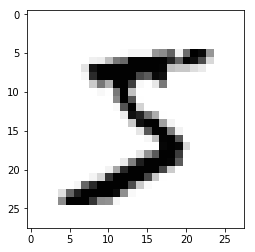

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)      #making flat array for examples
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0].reshape(28,28), cmap="Greys");

In [2]:
import tensorflow as tf
s1 = tf.InteractiveSession()

In [3]:
import numpy as np

In [10]:
train = (X_train, y_train)
test = (X_test, y_test)
val = (X_val, y_val)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from IPython.display import clear_output

In [15]:
class Network:
    
    def __init__(self, layers, activation=lambda x: tf.sigmoid(x), output=lambda x: x):
        """
        Make list of weight and biases matrices as variables. 
        w_ij - weight between j neuron in l-1 layer and i neuron in l layer.
        layers is the list containing the information about how many neurons are there in different layers.
        Xavier initialization of weights is implemented: stdev = (2/n_in)**0.5
        For example, network [28,50,10] will have 28 input chanels, 50 neurons in hidden layer and 10 output neurons.
        activation - activation function of neurons in the hidden layers except for the last layer
        output - activation function of neurons in the last layer
        """
        
        self.layers = layers
        self.biases = [tf.Variable(tf.zeros([y,1]), name="biases%i" % (y)) for y in layers[1:]]
        self.weights = [tf.Variable(tf.random_normal([x,y], mean=0.0, stddev=(2/y)**0.5), name="weights%i" % (y)) for x,y in zip(layers[1:],layers[:-1])]
        self.input_x = tf.placeholder(dtype='float32', shape=None, name="input_x")
        self.input_y = tf.placeholder(dtype='int64', shape=None, name="input_y")
        self.onehot = tf.placeholder(dtype='float32', shape=None, name="onehot_y")       #Placeholder for input_y in onehot form
        self.activation = activation
        self.output = output
        
    
    def make_prediction(self):
        """
        construct a function which output is the matrix where each column coresponds 
        to the example and contain probabilities (softmax is used)
        """
        y_pred = tf.transpose(self.input_x)          #make columns from rows of features
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            y_pred = self.activation(tf.matmul(w, y_pred) + b)         #forward activation
        y_pred = self.output(tf.matmul(self.weights[-1], y_pred) + self.biases[-1])          #last layer output
        y_pred = tf.nn.softmax(y_pred, 0)
        return y_pred
        
    def make_step(self, training_data, batch_size, optimizer):
        ind = np.random.choice(training_data[1].shape[0], batch_size)        #random indices from training data
        mini_batch = (training_data[0][ind], training_data[1][ind])         #making mini_batch
        s1.run(optimizer, {self.input_x: mini_batch[0], self.onehot: self.onehot_matrix(mini_batch[1])}) #perform optimizer
    
    def onehot_matrix(self, y_true):
        y_true_onehot = [[int(i==y) for y in y_true] for i in range(self.layers[-1])] #example: from y_true=[0,2]
        return y_true_onehot                                                          #make [[1,0],[0,0][0,1]]
    
    def cross_entropy_loss(self):
        pred_for_correct1 = self.make_prediction() * self.onehot         #leaving predictions only for correct classes
        pred_for_correct2 = tf.reduce_sum(pred_for_correct1, 0)            #making from it 1-D array by summing along columns
        loss = tf.reduce_mean(-tf.log(pred_for_correct2))                #applying log and summing through examples
        return loss
    
    def evaluate(self):
        correct_answer = tf.argmax(self.make_prediction(), 0)         #choosing correct answer by maximum probability along columns
        difference = correct_answer - self.input_y                   #difference vector
        incorrect_number = tf.count_nonzero(difference)           #correct predictions only where 0 in difference vector
        correct_ratio = 1 - incorrect_number / tf.shape(difference, out_type='int64')[0]
        return correct_ratio
    
    def training_momentum(self, restore=False, save=True, training_data=train, steps=100, batch_size=10, eta=0.05, momentum=0.9, nesterov=False):
        optimizer = tf.train.MomentumOptimizer(eta, momentum, use_nesterov=nesterov).minimize(self.cross_entropy_loss(), var_list=[self.weights, self.biases])
        s1.run(tf.global_variables_initializer())
        if restore:
            saver.restore(s1, './model.chkpt')
        for i in range(steps):
            self.make_step(training_data, batch_size, optimizer)
        if save:
            saver.save(s1, './model.chkpt')
    
    def training_RMSprop(self, restore=False, save=True, training_data=train, steps=100, batch_size=10, eta=0.1, decay=0.9):
        optimizer = tf.train.RMSPropOptimizer(eta, decay, momentum=0.0, epsilon=1e-10).minimize(self.cross_entropy_loss(), var_list=[self.weights, self.biases])
        s1.run(tf.global_variables_initializer())
        if restore:
            saver.restore(s1, './model.chkpt')
        for i in range(steps):
            self.make_step(training_data, batch_size, optimizer)
        if save:
            saver.save(s1, './model.chkpt')
    
    def training_AdaDelta(self, restore=False, save=True, training_data=train, steps=100, batch_size=10, eta=0.01, rho=0.95):
        optimizer = tf.train.AdadeltaOptimizer(eta, rho, epsilon=1e-8).minimize(self.cross_entropy_loss(), var_list=[self.weights, self.biases])
        s1.run(tf.global_variables_initializer())
        if restore:
            saver.restore(s1, './model.chkpt')
        for i in range(steps):
            self.make_step(training_data, batch_size, optimizer)
        if save:
            saver.save(s1, './model.chkpt')
    
    def training_Adam(self, restore=False, save=True, training_data=train, steps=100, batch_size=10, eta=0.001, beta1=0.9, beta2=0.999):
        optimizer = tf.train.AdamOptimizer(eta, beta1, beta2, epsilon=1e-8).minimize(self.cross_entropy_loss(), var_list=[self.weights, self.biases])
        s1.run(tf.global_variables_initializer())
        if restore:
            saver.restore(s1, './model.chkpt')
        for i in range(steps):
            self.make_step(training_data, batch_size, optimizer)
        if save:
            saver.save(s1, './model.chkpt')
        
    def training(self, restore=False, save=True, training_data=train, steps=100, batch_size=10, eta=0.1):
        optimizer = tf.train.GradientDescentOptimizer(eta).minimize(self.cross_entropy_loss(), var_list=[self.weights, self.biases])
        s1.run(tf.global_variables_initializer())
        if restore:
            saver.restore(s1, './model.chkpt')
        for i in range(steps):
            self.make_step(training_data, batch_size, optimizer)
        if save:
            saver.save(s1, './model.chkpt')
    

In [16]:
nn = Network([784,500,200,200,100,10], activation=lambda x: tf.nn.relu(x), output=lambda x: x)

In [17]:
s1.run(tf.global_variables_initializer())

In [18]:
saver = tf.train.Saver()

Epoch 29
Val_accuracy 0.9792


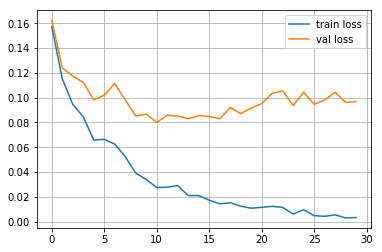

Test_accuracy 0.9807


In [20]:
nn.training_AdaDelta(restore=False, training_data=train, steps=400, batch_size=50, eta=1, rho=0.9)
train_log = []
val_log = []
for epoch in range(30):
    nn.training_AdaDelta(restore=True, training_data=train, steps=400, batch_size=50, eta=1, rho=0.9)
    clear_output()
    train_log.append(s1.run(nn.cross_entropy_loss(), {nn.input_x: train[0], nn.onehot: nn.onehot_matrix(train[1])}))
    val_log.append(s1.run(nn.cross_entropy_loss(), {nn.input_x: val[0], nn.onehot: nn.onehot_matrix(val[1])}))
    print("Epoch", epoch)
    print("Val_accuracy",s1.run(nn.evaluate(), {nn.input_x: val[0], nn.input_y: val[1]}))
    plt.plot(train_log, label='train loss')
    plt.plot(val_log, label='val loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
print("Test_accuracy",s1.run(nn.evaluate(), {nn.input_x: test[0], nn.input_y: test[1]}))

Feel free to try different network configurations and activation functions. 
Also my suggested protocol of optimization is not state of art and can be improved)
Try different optimizers, batch sizes, learning rates, steps and epoch numbers. Increasing steps to 1000 will give you accuracy near 98.5%.
Make experiments and report what should I improve.
Thank you and good luck in following tasks)